In [2]:
from fisher_dirtyecc import StableEMRIFisher, normal, cov_ellipse

import numpy as np
import cupy as cp
import warnings
import os

use_gpu = True


from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.utility import get_overlap, get_mismatch, get_separatrix, get_fundamental_frequencies
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.utils.constants import *
from few.utils.baseclasses import SchwarzschildEccentric, ParallelModuleBase
from few.waveform import AAKWaveformBase
from few.summation.aakwave import AAKSummation

import matplotlib.pyplot as plt

from few.utils.utility import get_p_at_t

import time
import warnings

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e8),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = EMRIInspiral(func="SchwarzEccGasSubFlux")  # added a new class to ode_base to include the gas torque effects in subsonic motion called SchwarzEccGasSubFlux#

In [3]:
# Intrinsic parameters
M = 1e6    # Primary mass (units of solar mass)
mu = 50  # Secondary mass (units of solar mass)
a = 0.0    # Primary spin parameter (a \in [0,1])
p0 = 12.6   # Initial semi-latus rectum (dimensionless)
e0 = 0.01   # Initial eccentricity (dimensionless)
iota0 = 0.0  # Initial inclination angle (with respect to the equatorial plane, (radians))
Y0 = np.cos(iota0)

Sigma_SI = 10**5
Sigma0 = Sigma_SI*M*MSUN_SI*G_SI**2/C_SI**4 #in units of M
h0 = 0.1
SigmaPower = -1.5

dist = 1.0   # Distance (units of giga-parsecs)

# Angular variables
qS = 1.5
phiS = 0.7
qK = 0.5
phiK = 0.9

# Initial angular phases -- positional elements along the orbit.
Phi_phi0 = 1.0   # Azimuthal phase
Phi_theta0 = 2.0   # Polar phase
Phi_r0 = 3.0    # Radial phase

# Waveform params
dt = 10.0  # Sampling interval [seconds]
T = 1     # Evolution time [years]

#p0_plunge = get_p_at_t(traj,T,[M,mu,0.,e0,Y0,Sigma0,SigmaPower,h0],traj_kwargs={'err':1e-12,'max_init_len':int(1e8)})

#print(p0_plunge)

In [4]:
"""
list of parameters varied in the Fisher analysis
available parameters for SchwarzEccGasSubFlux: {'M','mu','p0','e0','dist','qS','phiS','Phi_theta0','Phi_r0',
                                            'Sigma0','SigmaPower','h0'}
"""

param_names = ['M','mu','p0','e0','dist','qS','phiS','Phi_theta0','Phi_r0','Sigma0','SigmaPower','h0']
filename = 'TestRun_SubEcc'

#initialization
sef = StableEMRIFisher(M=M, mu=mu, a=a, p0=p0, e0=e0, Y0=Y0, Sigma0=Sigma0, SigmaPower=SigmaPower, h0=h0,\
                       dist=dist, qS=qS, phiS=phiS, qK=qK, phiK=phiK,\
                       Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,\
                       param_names=param_names, #explicitly specify the parameters to vary in Fisher
                       err=1e-14,filename=filename, 
                       CovMat=False, CovEllipse=False,
                      )
#execution
import time
st = time.time()
sef()
et = time.time()
print('time taken (sec): ', et - st)

/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19111 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/summation/aakwave.py:230: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  warnings.warn(


Waveform Generated. SNR:  30.454487374506346
calculating stable deltas...
M  =  1000100.0


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19099 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19088 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


0.046463103721768775
M  =  1000013.8949549437


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19047 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.1028009461313837
M  =  1000001.9306977289


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19090 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19241 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


214.95854644837954
M  =  1000000.2682695795


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19279 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19016 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


600.4615981856251
M  =  1000000.0372759372


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19159 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19130 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


611.4936235628901
M  =  1000000.0051794747


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19128 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19069 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


611.7069769414564
M  =  1000000.0007196857


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19042 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19144 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


611.7008501720543
M  =  1000000.0001


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19170 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19102 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


611.779377092795
[9.77904184e-01 9.90217644e-01 6.42011168e-01 1.80411127e-02
 3.48783628e-04 1.00159570e-05 1.28358234e-04]
[5]
mu  =  50.005


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18999 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19093 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


18995618.317813136
mu  =  50.00069474774719


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19063 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19125 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


654977192.3533859
mu  =  50.000096534886445


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19331 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19277 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


18883240718.728474
mu  =  50.000013413478975


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18958 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20574832280.891693
mu  =  50.00000186379686


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19066 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19065 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20608746808.9988
mu  =  50.000000258973735


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19020 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19250 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20609212463.406437
mu  =  50.000000035984286


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19084 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19140 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20610364458.526527
mu  =  50.000000005


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19237 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19248 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20620914509.61785
[9.70998046e-01 9.65314365e-01 8.22165420e-02 1.64563757e-03
 2.25944785e-05 5.58939713e-05 5.11618972e-04]
[4]
p0  =  12.60126


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19052 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19105 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


294854327.45145476
p0  =  12.60017507643229


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18911 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


15189021790.43913
p0  =  12.600024326791383


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19085 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19098 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


388208104355.3922
p0  =  12.600003380196702


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18853 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19070 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


14383807622097.586
p0  =  12.600000469676809


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19247 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19153 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


15508828745128.02
p0  =  12.60000006526138


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19224 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


15531234100511.047
p0  =  12.600000009068038


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19166 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19148 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


15531550864331.771
p0  =  12.60000000126


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18909 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19156 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


15532268130464.734
[9.80587668e-01 9.60874022e-01 9.73010755e-01 7.25406890e-02
 1.44259981e-03 2.03948610e-05 4.61790981e-05]
[5]
e0  =  0.010001


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18894 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26241685802.564842
e0  =  0.010000138949549438


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19035 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19178 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26241966433.656174
e0  =  0.01000001930697729


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18992 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26242699845.83335
e0  =  0.010000002682695795


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19183 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26237138246.715286
e0  =  0.010000000372759372


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18951 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19108 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26135026438.37547
e0  =  0.010000000051794748


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19110 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19122 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


25863226941.13505
e0  =  0.010000000007196856


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19302 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19303 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


26574954823.087162
e0  =  0.010000000001


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19256 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19420 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


24708652970.86699
[1.06939810e-05 2.79472837e-05 2.11974304e-04 3.90708648e-03
 1.05091100e-02 2.67819037e-02 7.55323188e-02]
[0]
qS  =  1.65
1040.2059824835692
qS  =  1.5077692120188468
1090.668425845816
qS  =  1.500402404369292
1090.8056690859719
qS  =  1.5000208424324155
1090.806037359345
qS  =  1.5000010795285095
1090.8060276018678
qS  =  1.5000000559139057
1090.8062901990643
qS  =  1.5000000028960465
1090.8495269074456
qS  =  1.50000000015
1108.4590903632777
[4.62674468e-02 1.25818231e-04 3.37615819e-07 8.94519929e-09
 2.40736782e-07 3.96358135e-05 1.58865254e-02]
[3]
phiS  =  0.7699999999999999
33519.33337750223
phiS  =  0.7036256322754618
36219.79471683518
phiS  =  0.7001877887056696
36227.29563348511
phiS  =  0.7000097264684606
36227.31577028244
phiS  =  0.700000503779971
36227.31546666747
phiS  =  0.700000026093156
36227.31991313681
phiS  =  0.7000000013514883
36227.60532622006
phiS  =  0.70000000007
36309.66506016524
[7.45576103e-02 2.07051521e-04 5.55845690e-07 8.38082999e-0

/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19067 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.1995157876964675e+27
Sigma0  =  1.102211260601842e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18861 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.2004428175533737e+27
Sigma0  =  1.0968259680243692e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19179 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18993 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.200629473807138e+27
Sigma0  =  1.0965470381589164e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19017 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19274 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.196148081956397e+27
Sigma0  =  1.0965325910571625e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19147 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19041 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.549519836768782e+27
Sigma0  =  1.0965318427731854e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19109 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19142 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.837102870493236e+27
Sigma0  =  1.0965318040160062e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19054 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19072 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.741227914670199e+28
Sigma0  =  1.0965318020085879e-13


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19172 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19289 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.648540208714692e+30
[2.20698126e-04 4.44353055e-05 1.06797753e-03 7.76723187e-02
 6.03579442e-01 8.96502481e-01 9.95147015e-01]
[1]
SigmaPower  =  -1.65


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18697 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19281 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.712080366090905
SigmaPower  =  -1.5077692120188468


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19075 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19094 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.706118263098806
SigmaPower  =  -1.500402404369292


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19151 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19207 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.705269962790573
SigmaPower  =  -1.5000208424324155


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18978 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19135 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.731369717958128
SigmaPower  =  -1.5000010795285095


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19050 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18941 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.469593705472431
SigmaPower  =  -1.5000000559139057


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19089 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19138 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


32.27753479054022
SigmaPower  =  -1.5000000028960465


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18935 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


562.2321728801668
SigmaPower  =  -1.50000000015


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18954 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19164 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


884001.9738828187
[1.04486145e-03 1.48687146e-04 4.55384253e-03 4.78602300e-02
 8.30544875e-01 9.42590381e-01 9.99363992e-01]
[1]
h0  =  0.11000000000000001
20847.39846750016
h0  =  0.10051794746792313


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19305 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18950 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20055.40229679294
h0  =  0.1000268269579528


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18987 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19184 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20049.164603943947
h0  =  0.10000138949549438


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19021 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19045 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


20030.664906728503
h0  =  0.1000000719685673


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18854 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


19666.43947613892
h0  =  0.10000000372759373


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19204 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19079 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


18266.873711641856
h0  =  0.10000000019306977


/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19312 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_dirtyecc/lib/python3.12/site-packages/few-1.4.11-py3.12-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19252 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1249909.5792498544
h0  =  0.10000000001
1539110.6846282112
[3.94904155e-02 3.11119838e-04 9.23568803e-04 1.85201511e-02
 7.66176953e-02 9.85385444e-01 1.87901434e-01]
[1]
stable deltas:  {'M': 0.005179474679231213, 'mu': 1.8637968601574688e-06, 'p0': 6.526138095831322e-08, 'e0': 1.0000000000000002e-06, 'qS': 2.0842432415597044e-05, 'phiS': 9.726468460611955e-06, 'Phi_theta0': 0.000536539159055945, 'Phi_r0': 0.0008048087385839177, 'Sigma0': 5.679458702907289e-16, 'SigmaPower': -0.007769212018846821, 'h0': 0.0005179474679231213}
calculating Fisher matrix...
M  =  1000000.0051794747
mu  =  50.00000186379686
p0  =  12.60000006526138
e0  =  0.010001
qS  =  1.5000208424324155
phiS  =  0.7000097264684606
Phi_theta0  =  2.000536539159056
Phi_r0  =  3.000804808738584
Sigma0  =  1.102211260601842e-13
SigmaPower  =  -1.5077692120188468
h0  =  0.10051794746792313
time taken (sec):  195.1466362476349


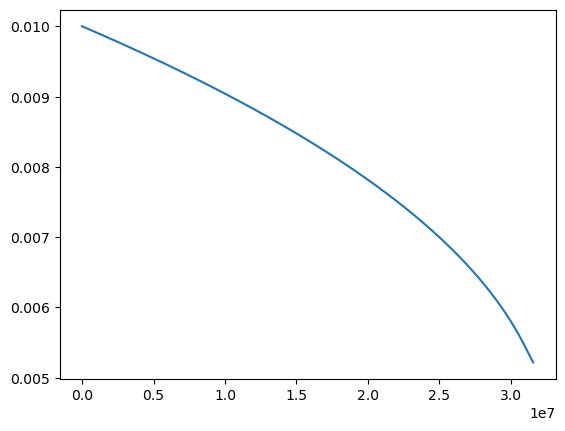

In [6]:
trajectory = traj(M,mu,a,p0,e0,Y0,Sigma0,SigmaPower,h0,Phi_phi0=0.,Phi_theta0=0.,Phi_r0=0.,err=1e-14,max_init_len=int(1e8))
plt.plot(trajectory[0],trajectory[2])

$1-\sigma$: 			 [9.76591421e+01 1.05678719e-02 1.38831062e-03 9.37492528e-03
 8.94296457e-02 3.94860866e-02 2.86803552e-02 2.65453843e-01
 4.37305734e+00 2.10135509e-09 2.23587217e+03 9.53465266e+02]


<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_8161/819953489.py:43: SyntaxWarning: invalid escape sequence '\s'
  print('$1-\sigma$: \t\t\t', np.sqrt(np.diag(covariance)))


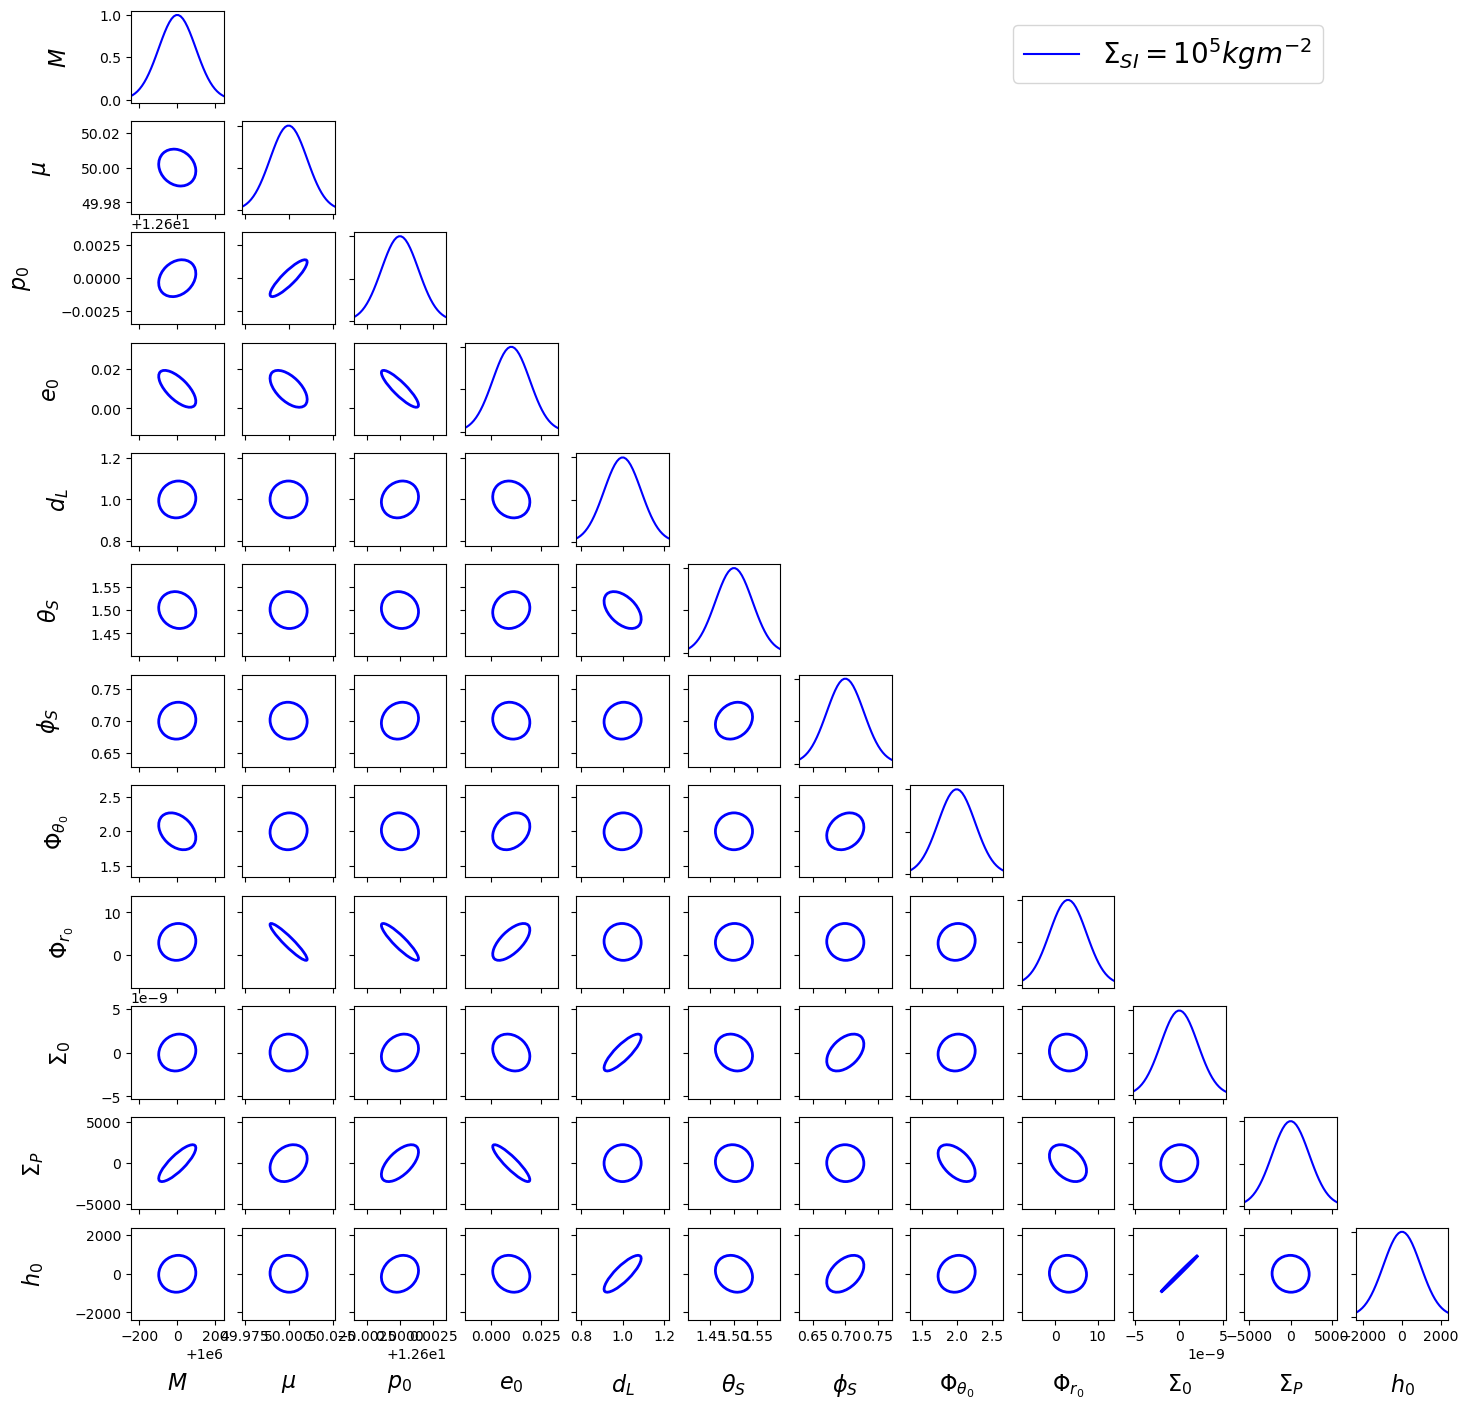

In [5]:
#Plotting

Fisher = np.loadtxt(f'{filename}/Fisher.txt')

#filename = 'pm_subdom_1'

param = {r'$M$':M,\
          r'$\mu$':mu,\
          #r'$a$':a,\
          r'$p_0$':p0,\
          r'$e_0$':e0,\
          #r'$Y_0$':Y0,\
          r'$\Sigma_0$':Sigma0,\
          r'$\Sigma_P$':SigmaPower,\
          r'$h_0$':h0,\
          r'$d_L$':dist,\
          r'$\theta_S$':qS,\
          r'$\phi_S$':phiS,\
          #r'$\Phi_{\phi_0}$':Phi_phi0,\
          r'$\Phi_{\theta_0}$':Phi_theta0,\
          r'$\Phi_{r_0}$':Phi_r0,\
          #r'$\theta_K$':qK,\
          #r'$\phi_K$':phiK
        }


param_names = [r'$M$',r'$\mu$',#r'$a$',
               r'$p_0$',r'$e_0$',#r'$Y_0$',
               r'$d_L$',r'$\theta_S$',r'$\phi_S$',
               #r'$\theta_K$',
               #r'$\phi_K$',
               #r'$\Phi_{\phi_0}$',
               r'$\Phi_{\theta_0}$',r'$\Phi_{r_0}$',
               r'$\Sigma_0$',r'$\Sigma_P$',r'$h_0$'
               ]
#paramaters

#######################################
### JOINT
#######################################

covariance = np.linalg.inv(Fisher)
print('$1-\sigma$: \t\t\t', np.sqrt(np.diag(covariance))) 

fig, axs = plt.subplots(len(param_names),len(param_names),figsize=(17,17))

#first param index
for i in range(len(param_names)):
    #second param index
    for j in range(i,len(param_names)):
        
        if i != j:
            cov = np.array(((covariance[i][i],covariance[i][j]),(covariance[j][i],covariance[j][j])))
            #print(cov)
            mean = np.array((param[param_names[i]],param[param_names[j]]))

            cov_ellipse(mean,cov,axs[j,i],lw=2,edgecolor='blue')

            #custom setting the x-y lim for each plot
            axs[j,i].set_xlim([param[param_names[i]]-2.5*np.sqrt(covariance[i][i]), param[param_names[i]]+2.5*np.sqrt(covariance[i][i])])
            axs[j,i].set_ylim([param[param_names[j]]-2.5*np.sqrt(covariance[j][j]), param[param_names[j]]+2.5*np.sqrt(covariance[j][j])])

            axs[j,i].set_xlabel(param_names[i],labelpad=20,fontsize=16)
            axs[j,i].set_ylabel(param_names[j],labelpad=20,fontsize=16)

        else:
            mean = param[param_names[i]]
            var = covariance[i][i]
            
            x = np.linspace(mean-3*np.sqrt(var),mean+3*np.sqrt(var))
            
            axs[j,i].plot(x,normal(mean,var,x),c='blue')
            axs[j,i].set_xlim([param[param_names[i]]-2.5*np.sqrt(covariance[i][i]), param[param_names[i]]+2.5*np.sqrt(covariance[i][i])])
            axs[j,i].set_xlabel(param_names[i],labelpad=20,fontsize=16)
            if i == j and j == 0:
                axs[j,i].set_ylabel(param_names[i],labelpad=20,fontsize=16)
    
    
for ax in fig.get_axes():
    ax.label_outer()
    
for i in range(len(param_names)):
    for j in range(i+1,len(param_names)):
        axs[i,j].axis('off')  # command for hiding the axis.
                
from matplotlib.lines import Line2D

axs[0,len(param_names)-2].legend([Line2D([0],[0],c='b'),
               #Line2D([0],[0],c='r'),
            #Line2D([0],[0],c='g'),
            #Line2D([0],[0],c='k'),
            #Line2D([0],[0],c='y'),
            #Line2D([0],[0],c='b'),
            #Line2D([0],[0],c='y')
                                 ],
           [r'$\Sigma_{SI} = 10^5 kgm^{-2}$',
            #r'($N_\delta = 8, n_{\rm{order}} = 2$) GitHub',
            #r'Extrinsic Sparse err = 5e-12 ($N_\delta = 8, n_{\rm{order}} = 2$) T = 289 sec',
            #r'$N_\delta = 8, n_{\rm{order}} = 4$',
            #r'$N_\delta = 8, n_{\rm{order}} = 2$, T ~ 1353 sec',
            #r'Dynamic Delta ($N_\delta = 8, n_{\rm{order}} = 2$) T ~ 890 sec',
            #r'Extrinsic Sparse ($N_\delta = 8, n_{\rm{order}} = 2$)'

            #'vacuum only'
           ],loc=1,fontsize=20)

plt.savefig(f'{filename}/Covariance.png',dpi=300,bbox_inches='tight')